# DistilBERT Notebook

This notebook contains fine-tuning a DistilBERT model for music genre classification using song lyrics, optionally adding metadata.

It includes:
- Label encoding of genres

- Metadata normalization

- Lyrics tokenization

- Dataset and DataLoader setup (`LyricsWithMetadataDataset` and `model_setup`)

- A model architecture combining DistilBERT embeddings with metadata features (`DistilBertWithMetadata`)

- The models are trained and evaluated using functions from `train_eval_utils.py`

The best model in the training is stored to `run_results/models/distilbert`

The restults are stored to `run_results/results/distilbert`


<br>
The code is inspired from:

- [Main inspiration: Lecture code - BERT implementation](https://colab.research.google.com/drive/1yWMwSUNhuoy-85KzR1th5e4aN8lR-UaY?usp=sharing)

- [DistilBERT - model documentation](https://huggingface.co/docs/transformers/model_doc/distilbert)

- [Using pre-trained BERT with PyTorch](https://neptune.ai/blog/how-to-code-bert-using-pytorch-tutorial)

- [ChatGPT](https://chatgpt.com/)



Training was conducted on Google Colab


In [1]:
try:
    # Comment out if not using colab
    from google.colab import drive
    drive.mount('/content/drive')

    %cd "/content/drive/Othercomputers/Min MacBook Pro/semester_project_info371"
except:
    print("Not using Google Colab")

Mounted at /content/drive
/content/drive/Othercomputers/Min MacBook Pro/semester_project_info371


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm

#Importing local functions
from train_eval_utils import train_model, evaluate_model, save_test_results

In [3]:
train_df = pd.read_csv("music_dataset_split/Train/training_data.csv")
val_df = pd.read_csv("music_dataset_split/Val/validation_data.csv")
test_df = pd.read_csv("music_dataset_split/Test/test_data.csv")

In [4]:
train_df.head(5)

,id,release_date,genre,lyrics,danceability
0,27780,2012,hip hop,wanna sound wanna sound feel marvelous right d...,0.541861
1,25749,1997,rock,time time time time time honk horn fuck fuck f...,0.753060
2,22028,1997,reggae,play game long start believe doubt try convinc...,0.710820
3,20445,2013,jazz,stop love mind live memories lonesome time sto...,0.596014
4,4885,2001,pop,people wanna kick nerd grow suburbs go wrong s...,0.463880


In [5]:
train_df['genre'].value_counts()

,count
genre,
pop,4870
country,3780
blues,3152
rock,2766
jazz,2582
reggae,1730
hip hop,630


In [6]:
train_df['release_date'].value_counts()

,count
release_date,
2017,460
2018,432
2012,415
2015,413
2009,400
...,...
1955,78
1952,43
1951,42


## DistilBERT

**Label encode genres**

In [7]:
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['genre'])
val_df['label'] = label_encoder.transform(val_df['genre'])
test_df['label'] = label_encoder.transform(test_df['genre'])

**Normalize metadata based on training set only**

In [8]:
scaler = MinMaxScaler()
scaler.fit(train_df[['release_date', 'danceability']])

train_df[['release_date', 'danceability']] = scaler.transform(train_df[['release_date', 'danceability']])
val_df[['release_date', 'danceability']] = scaler.transform(val_df[['release_date', 'danceability']])
test_df[['release_date', 'danceability']] = scaler.transform(test_df[['release_date', 'danceability']])

**Tokenization**

In [9]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [10]:
def tokenize_lyrics(df):
    return tokenizer(list(df['lyrics']), truncation=True, padding='max_length', max_length=256)

**Dataset class**

In [11]:
class LyricsWithMetadataDataset(Dataset):
    def __init__(self, df, encodings, use_release=True, use_dance=True):
        self.encodings = encodings
        self.labels = df['label'].tolist()

        selected_columns = []
        if use_release:
            selected_columns.append('release_date')
        if use_dance:
            selected_columns.append('danceability')

        self.metadata = df[selected_columns].values.astype('float32') if selected_columns else None
        self.use_metadata = bool(selected_columns)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.use_metadata:
            item['metadata'] = torch.tensor(self.metadata[idx])
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

**Model class for fine-tuning**

In [12]:
class DistilBertWithMetadata(nn.Module):
    def __init__(self, metadata_input_dim, num_labels):
        super().__init__()
        self.use_metadata = metadata_input_dim > 0
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(0.3)

        if self.use_metadata:
            self.metadata_dense = nn.Linear(metadata_input_dim, 768)
            self.classifier = nn.Linear(768 + 768, num_labels)
            print(f"[Model Setup] Metadata ENABLED")
        else:
            self.classifier = nn.Linear(768, num_labels)
            print("[Model Setup] Metadata DISABLED")

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    def forward(self, input_ids, attention_mask, metadata=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.last_hidden_state[:, 0])  # [CLS] token (768)

        if self.use_metadata and metadata is not None:
            metadata_embed = self.dropout(self.metadata_dense(metadata))
            combined = torch.cat((pooled_output, metadata_embed), dim=1)
            pooled_output = combined

        logits = self.classifier(pooled_output)
        return logits

**Model setup**

In [13]:
num_labels = len(label_encoder.classes_)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
def model_setup(use_release=True, use_dance=True):
    train_encodings = tokenize_lyrics(train_df)
    val_encodings = tokenize_lyrics(val_df)

    train_dataset = LyricsWithMetadataDataset(train_df, train_encodings, use_release, use_dance)
    val_dataset = LyricsWithMetadataDataset(val_df, val_encodings, use_release, use_dance)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    if use_release and use_dance:
        metadata_input_dim = 2
    elif use_release or use_dance:
        metadata_input_dim = 1
    else:
        metadata_input_dim = 0

    model = DistilBertWithMetadata(metadata_input_dim, num_labels=num_labels).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss()

    print("[Model Setup Complete] Starting training...")
    return model, optimizer, loss_fn, train_loader, val_loader


## Training and evaluation our model

**Test set setup**

In [15]:
test_encodings = tokenize_lyrics(test_df)

No metadata - testset

In [16]:
no_md_test_dataset = LyricsWithMetadataDataset(test_df, test_encodings, use_release=False, use_dance=False)
no_md_test_loader = DataLoader(no_md_test_dataset, batch_size=16)

Year as metadata setup

In [17]:
year_test_dataset = LyricsWithMetadataDataset(test_df, test_encodings, use_release=True, use_dance=False)
year_test_loader = DataLoader(no_md_test_dataset, batch_size=16)

Dancability as metadata setup

In [18]:
dance_test_dataset = LyricsWithMetadataDataset(test_df, test_encodings, use_release=False, use_dance=True)
dance_test_loader = DataLoader(dance_test_dataset, batch_size=16)

Year and Danceability as metadata setup

In [19]:
year_dance_test_dataset = LyricsWithMetadataDataset(test_df, test_encodings, use_release=True, use_dance=True)
year_dance_test_loader = DataLoader(year_dance_test_dataset, batch_size=16)

## **Run training and testing**


In [20]:
no_md_model = train_model(
    use_release=False,
    use_dance=False,
    epochs=5,
    description="distilbert/no_metadata_distilbert",
    model_setup_encoder=model_setup
)


------ Metadata Usage Configuration ------
Using release_year: False
Using danceability: False


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

[Model Setup] Metadata DISABLED
[Model Setup Complete] Starting training...


Epoch 1 Training: 100%|██████████| 1220/1220 [03:05<00:00,  6.58it/s]



Epoch 1, Train Loss: 1.5987, Train Accuracy: 0.3637

validation score: Val Loss: 1.51, Val Accuracy: 0.41
[Best Model Saved] Epoch 1 with val loss: 1.5057


Epoch 2 Training: 100%|██████████| 1220/1220 [03:06<00:00,  6.53it/s]



Epoch 2, Train Loss: 1.4050, Train Accuracy: 0.4597

validation score: Val Loss: 1.46, Val Accuracy: 0.43
[Best Model Saved] Epoch 2 with val loss: 1.4606


Epoch 3 Training: 100%|██████████| 1220/1220 [03:06<00:00,  6.52it/s]



Epoch 3, Train Loss: 1.2079, Train Accuracy: 0.5493

validation score: Val Loss: 1.55, Val Accuracy: 0.41


Epoch 4 Training: 100%|██████████| 1220/1220 [03:06<00:00,  6.53it/s]



Epoch 4, Train Loss: 0.9359, Train Accuracy: 0.6590

validation score: Val Loss: 1.73, Val Accuracy: 0.42


Epoch 5 Training: 100%|██████████| 1220/1220 [03:06<00:00,  6.53it/s]



Epoch 5, Train Loss: 0.6412, Train Accuracy: 0.7745

validation score: Val Loss: 2.04, Val Accuracy: 0.39

[Model Restored] Loaded best model from epoch 2 with val loss: 1.4606


[Evaluation] Model loaded from file 'no_metadata_distilbert' (epoch 2, val_loss: 1.4606)
Test - No metadata - DistilBERT Accuracy: 0.43

Classification Report:
              precision    recall  f1-score   support

       blues       0.36      0.35      0.36       676
     country       0.48      0.62      0.54       810
     hip hop       0.89      0.53      0.66       135
        jazz       0.38      0.41      0.40       553
         pop       0.38      0.46      0.42      1044
      reggae       0.56      0.42      0.48       371
        rock       0.55      0.24      0.33       592

    accuracy                           0.43      4181
   macro avg       0.51      0.43      0.46      4181
weighted avg       0.45      0.43      0.43      4181



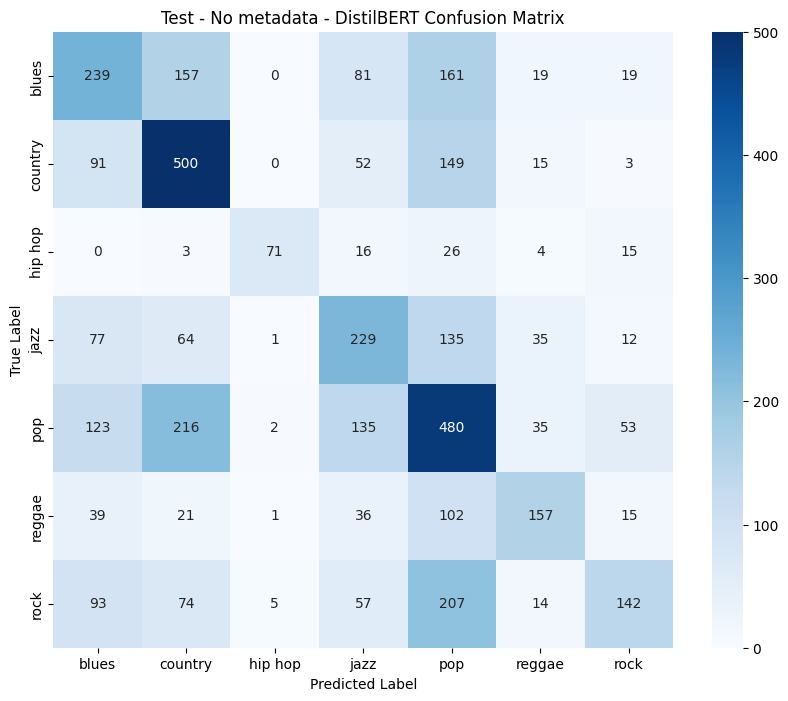

[Saved] Test results saved to: run_results/results/distilbert/results_no_metadata_db


In [21]:
evaluate_model(
    no_md_model,
    no_md_test_loader,
    label="Test - No metadata - DistilBERT",
    folder = "distilbert/",
    description = "no_metadata_distilbert",
    file_name="results_no_metadata_db",
    label_encoder=label_encoder
)


**Run training - Lyrics + release year**

In [22]:
year_model = train_model(
    use_release=True,
    use_dance=False,
    epochs=5,
    description="distilbert/year_distilbert",
    model_setup_encoder=model_setup
)


------ Metadata Usage Configuration ------
Using release_year: True
Using danceability: False
[Model Setup] Metadata ENABLED
[Model Setup Complete] Starting training...


Epoch 1 Training: 100%|██████████| 1220/1220 [03:07<00:00,  6.52it/s]



Epoch 1, Train Loss: 1.6018, Train Accuracy: 0.3589

validation score: Val Loss: 1.48, Val Accuracy: 0.42
[Best Model Saved] Epoch 1 with val loss: 1.4842


Epoch 2 Training: 100%|██████████| 1220/1220 [03:07<00:00,  6.52it/s]



Epoch 2, Train Loss: 1.4011, Train Accuracy: 0.4603

validation score: Val Loss: 1.46, Val Accuracy: 0.42
[Best Model Saved] Epoch 2 with val loss: 1.4629


Epoch 3 Training: 100%|██████████| 1220/1220 [03:07<00:00,  6.52it/s]



Epoch 3, Train Loss: 1.1967, Train Accuracy: 0.5576

validation score: Val Loss: 1.53, Val Accuracy: 0.43


Epoch 4 Training: 100%|██████████| 1220/1220 [03:07<00:00,  6.52it/s]



Epoch 4, Train Loss: 0.9337, Train Accuracy: 0.6653

validation score: Val Loss: 1.66, Val Accuracy: 0.42


Epoch 5 Training: 100%|██████████| 1220/1220 [03:07<00:00,  6.52it/s]



Epoch 5, Train Loss: 0.6524, Train Accuracy: 0.7744

validation score: Val Loss: 1.95, Val Accuracy: 0.40

[Model Restored] Loaded best model from epoch 2 with val loss: 1.4629


[Evaluation] Model loaded from file 'year_distilbert' (epoch 2, val_loss: 1.4629)
Test - with release year - DistilBERT Accuracy: 0.43

Classification Report:
              precision    recall  f1-score   support

       blues       0.38      0.36      0.37       676
     country       0.58      0.47      0.52       810
     hip hop       0.89      0.54      0.67       135
        jazz       0.44      0.27      0.33       553
         pop       0.36      0.55      0.44      1044
      reggae       0.70      0.32      0.43       371
        rock       0.36      0.42      0.39       592

    accuracy                           0.43      4181
   macro avg       0.53      0.42      0.45      4181
weighted avg       0.46      0.43      0.43      4181



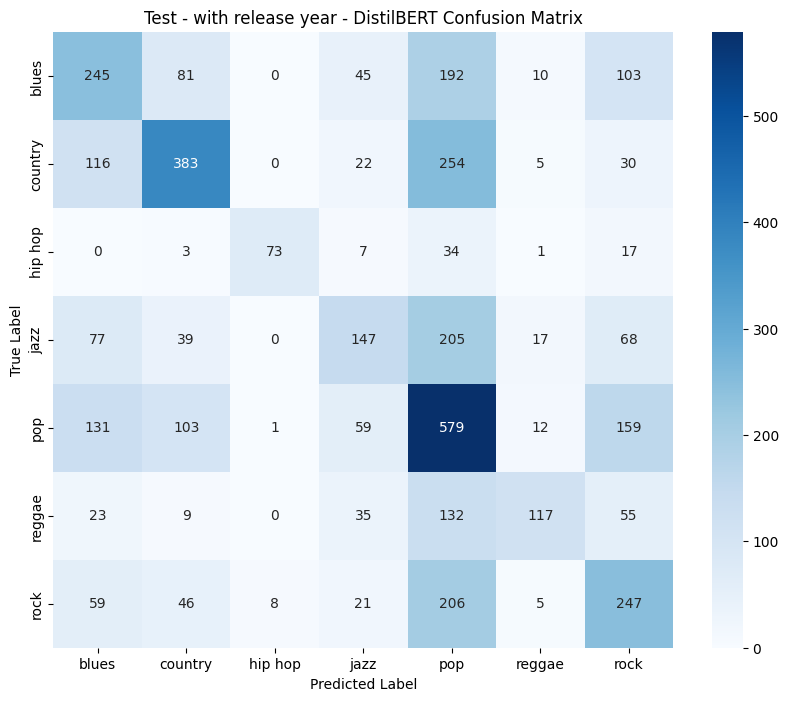

[Saved] Test results saved to: run_results/results/distilbert/results_year_distilbert


In [23]:
evaluate_model(
    year_model,
    year_test_loader,
    label="Test - with release year - DistilBERT",
    folder = "distilbert/",
    description = "year_distilbert",
    file_name="results_year_distilbert",
    label_encoder=label_encoder
)

**Run training - Lyrics + dancability**

In [25]:
dance_model = train_model(
    use_release=False,
    use_dance=True,
    epochs=5,
    description="distilbert/dance_distilbert",
    model_setup_encoder=model_setup
)


------ Metadata Usage Configuration ------
Using release_year: False
Using danceability: True
[Model Setup] Metadata ENABLED
[Model Setup Complete] Starting training...


Epoch 1 Training: 100%|██████████| 1220/1220 [03:07<00:00,  6.52it/s]



Epoch 1, Train Loss: 1.5864, Train Accuracy: 0.3672

validation score: Val Loss: 1.47, Val Accuracy: 0.42
[Best Model Saved] Epoch 1 with val loss: 1.4718


Epoch 2 Training: 100%|██████████| 1220/1220 [03:07<00:00,  6.52it/s]



Epoch 2, Train Loss: 1.3745, Train Accuracy: 0.4695

validation score: Val Loss: 1.43, Val Accuracy: 0.44
[Best Model Saved] Epoch 2 with val loss: 1.4281


Epoch 3 Training: 100%|██████████| 1220/1220 [03:07<00:00,  6.51it/s]



Epoch 3, Train Loss: 1.1690, Train Accuracy: 0.5617

validation score: Val Loss: 1.51, Val Accuracy: 0.42


Epoch 4 Training: 100%|██████████| 1220/1220 [03:07<00:00,  6.52it/s]



Epoch 4, Train Loss: 0.8970, Train Accuracy: 0.6752

validation score: Val Loss: 1.64, Val Accuracy: 0.42


Epoch 5 Training: 100%|██████████| 1220/1220 [03:07<00:00,  6.52it/s]



Epoch 5, Train Loss: 0.6101, Train Accuracy: 0.7894

validation score: Val Loss: 1.98, Val Accuracy: 0.41

[Model Restored] Loaded best model from epoch 2 with val loss: 1.4281


[Evaluation] Model loaded from file 'dance_distilbert' (epoch 2, val_loss: 1.4281)
Test - with danceability - DistilBERT Accuracy: 0.45

Classification Report:
              precision    recall  f1-score   support

       blues       0.40      0.34      0.37       676
     country       0.55      0.53      0.54       810
     hip hop       0.96      0.51      0.67       135
        jazz       0.37      0.43      0.40       553
         pop       0.39      0.48      0.43      1044
      reggae       0.53      0.57      0.55       371
        rock       0.47      0.36      0.41       592

    accuracy                           0.45      4181
   macro avg       0.53      0.46      0.48      4181
weighted avg       0.46      0.45      0.45      4181



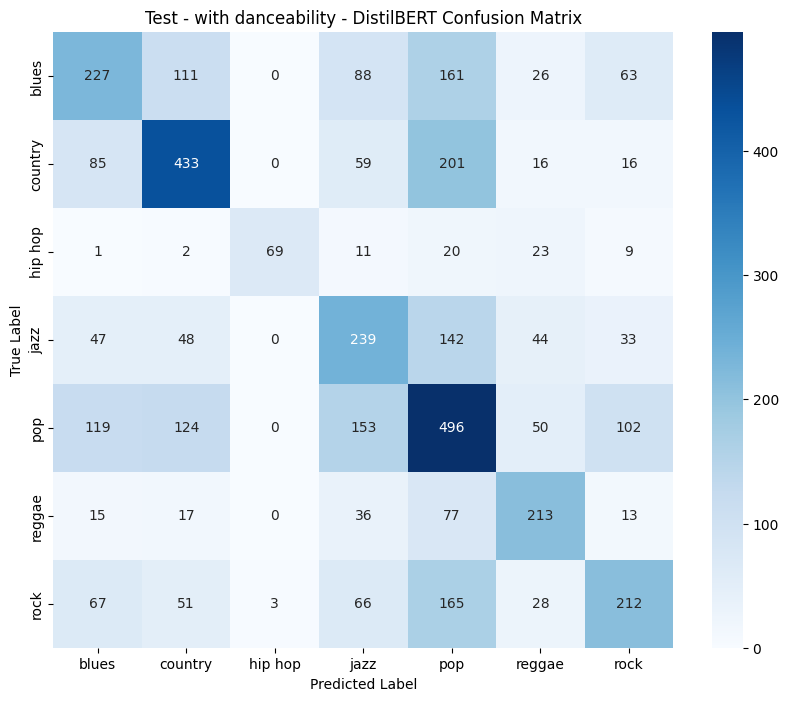

[Saved] Test results saved to: run_results/results/distilbert/results_dance_distilbert


In [26]:
evaluate_model(
    dance_model,
    dance_test_loader,
    label="Test - with danceability - DistilBERT",
    folder = "distilbert/",
    description = "dance_distilbert",
    file_name="results_dance_distilbert",
    label_encoder=label_encoder
)

**Run training - Lyrics + release year and dancability**

In [28]:
both_model = train_model(
    use_release=True,
    use_dance=True,
    epochs=5,
    description="distilbert/both_md_distilbert",
    model_setup_encoder=model_setup
)


------ Metadata Usage Configuration ------
Using release_year: True
Using danceability: True
[Model Setup] Metadata ENABLED
[Model Setup Complete] Starting training...


Epoch 1 Training: 100%|██████████| 1220/1220 [03:07<00:00,  6.51it/s]



Epoch 1, Train Loss: 1.5879, Train Accuracy: 0.3671

validation score: Val Loss: 1.46, Val Accuracy: 0.42
[Best Model Saved] Epoch 1 with val loss: 1.4622


Epoch 2 Training: 100%|██████████| 1220/1220 [03:07<00:00,  6.51it/s]



Epoch 2, Train Loss: 1.3702, Train Accuracy: 0.4772

validation score: Val Loss: 1.43, Val Accuracy: 0.44
[Best Model Saved] Epoch 2 with val loss: 1.4286


Epoch 3 Training: 100%|██████████| 1220/1220 [03:07<00:00,  6.51it/s]



Epoch 3, Train Loss: 1.1743, Train Accuracy: 0.5618

validation score: Val Loss: 1.50, Val Accuracy: 0.43


Epoch 4 Training: 100%|██████████| 1220/1220 [03:07<00:00,  6.52it/s]



Epoch 4, Train Loss: 0.9129, Train Accuracy: 0.6714

validation score: Val Loss: 1.64, Val Accuracy: 0.42


Epoch 5 Training: 100%|██████████| 1220/1220 [03:07<00:00,  6.52it/s]



Epoch 5, Train Loss: 0.6351, Train Accuracy: 0.7811

validation score: Val Loss: 1.93, Val Accuracy: 0.41

[Model Restored] Loaded best model from epoch 2 with val loss: 1.4286


[Evaluation] Model loaded from file 'both_md_distilbert' (epoch 2, val_loss: 1.4286)
Test - with year and danceability - DistilBERT Accuracy: 0.45

Classification Report:
              precision    recall  f1-score   support

       blues       0.41      0.34      0.37       676
     country       0.52      0.53      0.52       810
     hip hop       0.94      0.55      0.69       135
        jazz       0.44      0.25      0.32       553
         pop       0.38      0.57      0.45      1044
      reggae       0.47      0.53      0.50       371
        rock       0.48      0.34      0.40       592

    accuracy                           0.45      4181
   macro avg       0.52      0.44      0.47      4181
weighted avg       0.46      0.45      0.44      4181



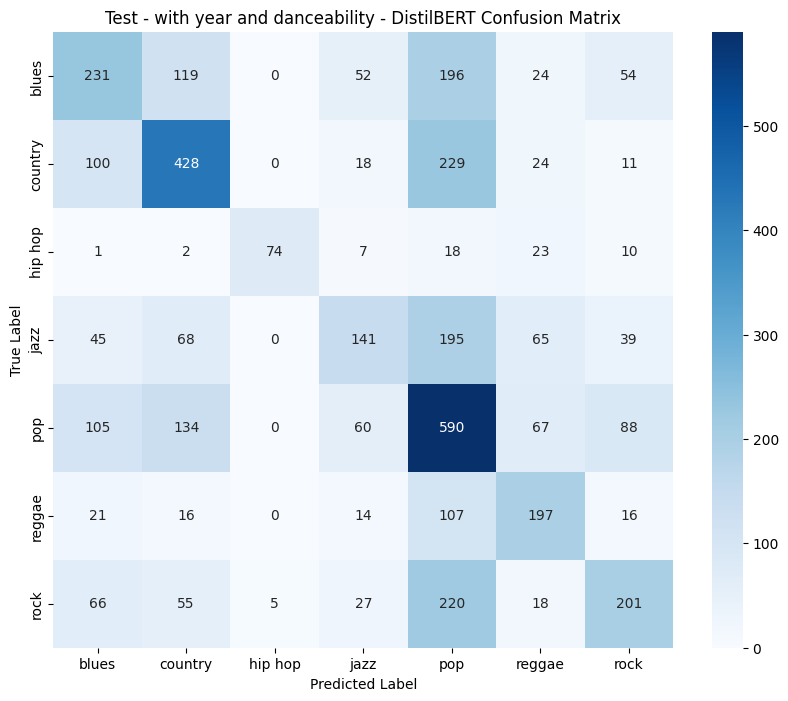

[Saved] Test results saved to: run_results/results/distilbert/results_both_md_ditilbert


In [29]:
evaluate_model(
    both_model,
    year_dance_test_loader,
    label="Test - with year and danceability - DistilBERT",
    folder = "distilbert/",
    description = "both_md_distilbert",
    file_name="results_both_md_ditilbert",
    label_encoder=label_encoder
)